# **Download ERA T2M** from Copernicus 
## and **Create ZARR** for Anemoi, Explore ZARR

<xarray.Dataset> Size: 804MB
Dimensions:     (valid_time: 31, latitude: 1801, longitude: 3600)
Coordinates:
    number      int64 8B ...
  * latitude    (latitude) float64 14kB 90.0 89.9 89.8 ... -89.8 -89.9 -90.0
  * longitude   (longitude) float64 29kB 0.0 0.1 0.2 0.3 ... 359.7 359.8 359.9
  * valid_time  (valid_time) datetime64[ns] 248B 2025-01-01 ... 2025-01-31
Data variables:
    t2m         (valid_time, latitude, longitude) float32 804MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-05-23T20:32 GRIB to CDM+CF via cfgrib-0.9.1...


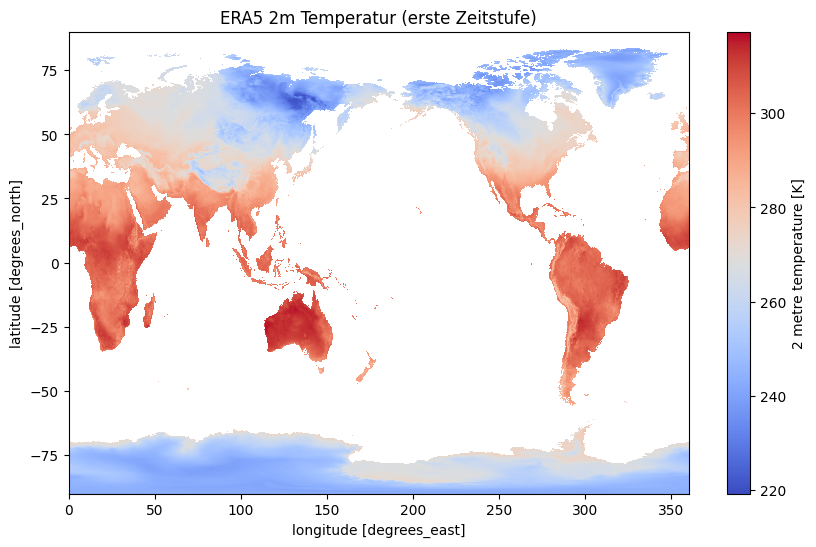

In [1]:
import xarray as xr
import matplotlib.pyplot as plt

# Datei laden (Pfad anpassen)
ds = xr.open_dataset('era_t2m.nc')

# Übersicht der Variablen
print(ds)

# Beispiel: 2m Temperatur Variable (häufig 't2m')
# Erste Zeitstufe auswählen (Index 0)
# Erste Zeitstufe auswählen (Index 0) über 'valid_time'
t2m = ds['t2m'].isel(valid_time=0)

# Plotten
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
t2m.plot(cmap='coolwarm')
plt.title('ERA5 2m Temperatur (erste Zeitstufe)')
plt.savefig("era_t2m_2025_01_01_00.png")
plt.show()


In [2]:
# Find all Times downloaded
import numpy as np
import xarray as xr

# Datei laden (Pfad anpassen)
ds = xr.open_dataset('era_t2m.nc')

for t in ds.valid_time.values:
    print(np.datetime_as_string(t, unit='h'), end=', ')

2025-01-01T00, 2025-01-02T00, 2025-01-03T00, 2025-01-04T00, 2025-01-05T00, 2025-01-06T00, 2025-01-07T00, 2025-01-08T00, 2025-01-09T00, 2025-01-10T00, 2025-01-11T00, 2025-01-12T00, 2025-01-13T00, 2025-01-14T00, 2025-01-15T00, 2025-01-16T00, 2025-01-17T00, 2025-01-18T00, 2025-01-19T00, 2025-01-20T00, 2025-01-21T00, 2025-01-22T00, 2025-01-23T00, 2025-01-24T00, 2025-01-25T00, 2025-01-26T00, 2025-01-27T00, 2025-01-28T00, 2025-01-29T00, 2025-01-30T00, 2025-01-31T00, 

## Convert to ZARR

In [3]:
import xarray as xr
import os
import logging
import traceback

from anemoi.datasets.data import open_dataset
from anemoi.datasets.data import add_dataset_path

logging.basicConfig(level=logging.DEBUG, format='%(levelname)s: %(name)s: %(message)s')
LOG = logging.getLogger(__name__)

netcdf_file_path = "era_t2m.nc"
zarr_archive_path = "era_t2m.zarr"

print(f"Attempting to convert '{netcdf_file_path}' to '{zarr_archive_path}'...")

try:
    # Open the NetCDF file with xarray
    ds_netcdf = xr.open_dataset(netcdf_file_path)
    print(f"Successfully opened NetCDF dataset:\n{ds_netcdf}")

    # IMPORTANT CHANGE: Rename the 't2m' variable to 'data' for Anemoi compatibility
    ds_renamed = ds_netcdf.rename_vars({'t2m': 'data'})
    print(f"Dataset after renaming 't2m' to 'data':\n{ds_renamed}")

    # Ensure overwrite and force computation when saving to Zarr
    ds_renamed.to_zarr(zarr_archive_path, mode='w', compute=True, consolidated=True)

    print(f"Successfully converted '{netcdf_file_path}' to Zarr at '{zarr_archive_path}'")

    # Calculate and print the size of the Zarr directory
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(zarr_archive_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_size += os.path.getsize(fp)
    LOG.info(f"Calculated size of Zarr directory '{zarr_archive_path}' after conversion: {total_size / (1024*1024):.2f} MB")

    # Add the directory containing the Zarr archive to Anemoi's search paths
    current_dir = os.path.dirname(os.path.abspath(zarr_archive_path))
    add_dataset_path(current_dir)
    LOG.info(f"Added dataset path to Anemoi search: {current_dir}")

    print(f"Attempting to open '{zarr_archive_path}' with Anemoi's open_dataset...")
    ds_anemoi = open_dataset("era_t2m.zarr") # Open the .zarr file with its exact name
    print(f"Successfully opened dataset with Anemoi:\n{ds_anemoi}")

    print("\n--- Detailed Anemoi Dataset Information ---")

    # Print the main data variable ('data')
    print("\nMain Data Variable ('data'):")
    print(ds_anemoi.data)

    # Access and print coordinates (latitude, longitude, valid_time) from the underlying Zarr group
    print("\nLatitude Coordinates:")
    print(ds_anemoi.z['latitude'])

    print("\nLongitude Coordinates:")
    print(ds_anemoi.z['longitude'])

    print("\nValid Time Coordinates:")
    print(ds_anemoi.z['valid_time'])

    # You can also print the underlying Zarr group itself for a high-level view of its contents
    print("\nUnderlying Zarr Group (ds_anemoi.z):")
    print(ds_anemoi.z)

except FileNotFoundError:
    print(f"Error: The NetCDF file '{netcdf_file_path}' was not found. Please ensure it's in the correct directory.")
except Exception as e:
    print("\n--- AN ERROR OCCURRED ---")
    print(f"Error type: {type(e).__name__}")
    print(f"Error message: {e}")
    print("\nFull Traceback:")
    traceback.print_exc()
    print("-------------------------")

Attempting to convert 'era_t2m.nc' to 'era_t2m.zarr'...
Successfully opened NetCDF dataset:
<xarray.Dataset> Size: 804MB
Dimensions:     (valid_time: 31, latitude: 1801, longitude: 3600)
Coordinates:
    number      int64 8B ...
  * latitude    (latitude) float64 14kB 90.0 89.9 89.8 ... -89.8 -89.9 -90.0
  * longitude   (longitude) float64 29kB 0.0 0.1 0.2 0.3 ... 359.7 359.8 359.9
  * valid_time  (valid_time) datetime64[ns] 248B 2025-01-01 ... 2025-01-31
Data variables:
    t2m         (valid_time, latitude, longitude) float32 804MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-05-23T20:32 GRIB to CDM+CF via cfgrib-0.9.1...
Dataset after renaming 't2m' to 'data':
<xarray.Dataset> Size: 804MB
Dimensions:     (valid_time: 31, 

INFO: __main__: Calculated size of Zarr directory 'era_t2m.zarr' after conversion: 145.95 MB
INFO: __main__: Added dataset path to Anemoi search: /mnt/c/Users/rolan/all/python_and_ml_tutorial/code/code16


Attempting to open 'era_t2m.zarr' with Anemoi's open_dataset...
Successfully opened dataset with Anemoi:
era_t2m.zarr

--- Detailed Anemoi Dataset Information ---

Main Data Variable ('data'):
<zarr.core.Array '/data' (31, 1801, 3600) float32 read-only>

Latitude Coordinates:
<zarr.core.Array '/latitude' (1801,) float64 read-only>

Longitude Coordinates:
<zarr.core.Array '/longitude' (3600,) float64 read-only>

Valid Time Coordinates:
<zarr.core.Array '/valid_time' (31,) int64 read-only>

Underlying Zarr Group (ds_anemoi.z):
<zarr.hierarchy.Group '/' read-only>


# Now a) inpspect, b) read and c) visualize the zarr

In [4]:
# a) inspect ZARR
import xarray as xr

# Reopen the Zarr dataset using xarray directly
zarr_archive_path = "era_t2m.zarr"
ds_zarr = xr.open_zarr(zarr_archive_path, consolidated=True)

print(ds_zarr)

<xarray.Dataset> Size: 804MB
Dimensions:     (valid_time: 31, latitude: 1801, longitude: 3600)
Coordinates:
  * latitude    (latitude) float64 14kB 90.0 89.9 89.8 ... -89.8 -89.9 -90.0
  * longitude   (longitude) float64 29kB 0.0 0.1 0.2 0.3 ... 359.7 359.8 359.9
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 248B 2025-01-01 ... 2025-01-31
Data variables:
    data        (valid_time, latitude, longitude) float32 804MB dask.array<chunksize=(4, 226, 450), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    history:                 2025-05-23T20:32 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts


In [5]:
# a) List variables in the dataset
print("Variables in Zarr Dataset:")
for var in ds_zarr.data_vars:
    print(f" - {var}")

# Inspect coordinates
print("\nCoordinates:")
for coord in ds_zarr.coords:
    print(f" - {coord}: shape={ds_zarr[coord].shape}")

Variables in Zarr Dataset:
 - data

Coordinates:
 - latitude: shape=(1801,)
 - longitude: shape=(3600,)
 - number: shape=()
 - valid_time: shape=(31,)


DEBUG: matplotlib.colorbar: locator: <matplotlib.ticker.AutoLocator object at 0x7eff42d5a360>


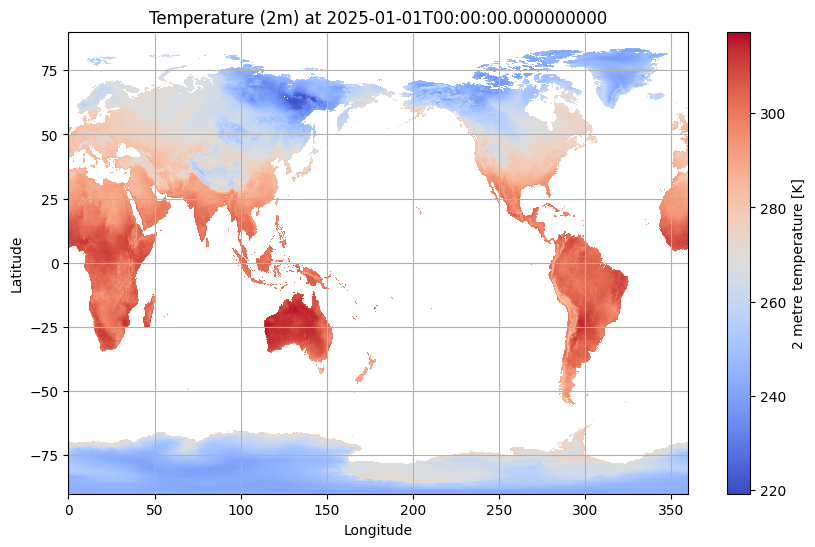

In [6]:
# b) read and c) display time slice
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.WARNING)  # or ERROR, CRITICAL

# Select a time slice (first available time)
time_slice = ds_zarr.isel(valid_time=0)

# Plot the data
plt.figure(figsize=(10, 6))
time_slice.data.plot(cmap='coolwarm')
plt.title(f"Temperature (2m) at {str(time_slice.valid_time.values)}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.savefig("era_t2m_2025_01_01_00.png")
plt.show()

In [7]:
import os
import zarr

# Path to the Zarr archive
zarr_path = "era_t2m.zarr"

# List the contents of the top-level directory
print("📁 Top-level structure in Zarr archive:")
for item in os.listdir(zarr_path):
    print("", item)

# Explore the 'data' variable directory
data_var_path = os.path.join(zarr_path, "data")
print("\n📦 Files/chunks inside 'data/' (showing first 10):")
for chunk in sorted(os.listdir(data_var_path))[:10]:
    print(" -", chunk)

# Optional: open with zarr and inspect shape & chunk layout
zarr_group = zarr.open_consolidated(zarr_path)
print("\n📐 Chunking of 'data' array:")
print("Shape:", zarr_group["data"].shape)
print("Chunks:", zarr_group["data"].chunks)

📁 Top-level structure in Zarr archive:
 .zattrs
 .zgroup
 .zmetadata
 data
 latitude
 longitude
 number
 valid_time

📦 Files/chunks inside 'data/' (showing first 10):
 - .zarray
 - .zattrs
 - 0.0.0
 - 0.0.1
 - 0.0.2
 - 0.0.3
 - 0.0.4
 - 0.0.5
 - 0.0.6
 - 0.0.7

📐 Chunking of 'data' array:
Shape: (31, 1801, 3600)
Chunks: (4, 226, 450)


In [8]:
import os
import numpy as np

# Path to the Zarr chunk file
chunk_path = "era_t2m.zarr/data/0.0.0"

# Read raw binary data
with open(chunk_path, "rb") as f:
    chunk_bytes = f.read()

print(f"Chunk file size: {len(chunk_bytes)} bytes")

# Try decoding it using NumPy (requires knowledge of dtype and shape)
import zarr
z = zarr.open_consolidated("era_t2m.zarr")
array = z["data"]

print("\nArray shape:", array.shape)
print("Chunk shape:", array.chunks)
print("Dtype:", array.dtype)

# Compute chunk indices and shape
chunk_indices = (0, 0, 0)
chunk_shape = array.chunks

# Convert chunk index to slices
slices = tuple(
    slice(ci * cs, (ci + 1) * cs)
    for ci, cs in zip(chunk_indices, chunk_shape)
)

# Load chunk data using slicing
chunk_data = array[slices]

print("📊 Chunk (0,0,0) data shape:", chunk_data.shape)
print("Sample values:")
print(chunk_data)


Chunk file size: 107544 bytes

Array shape: (31, 1801, 3600)
Chunk shape: (4, 226, 450)
Dtype: float32
📊 Chunk (0,0,0) data shape: (4, 226, 450)
Sample values:
[[[      nan       nan       nan ...       nan       nan       nan]
  [      nan       nan       nan ...       nan       nan       nan]
  [      nan       nan       nan ...       nan       nan       nan]
  ...
  [      nan       nan       nan ... 271.73837 271.67783 271.6212 ]
  [      nan       nan       nan ... 271.7872  271.68564 271.62314]
  [      nan       nan       nan ... 271.6622  271.5997  271.545  ]]

 [[      nan       nan       nan ...       nan       nan       nan]
  [      nan       nan       nan ...       nan       nan       nan]
  [      nan       nan       nan ...       nan       nan       nan]
  ...
  [      nan       nan       nan ... 268.39618 268.35907 268.3083 ]
  [      nan       nan       nan ... 268.2751  268.22235 268.19696]
  [      nan       nan       nan ... 268.13055 268.11102 268.10126]]

 [[     

DEBUG: matplotlib.colorbar: locator: <matplotlib.ticker.AutoLocator object at 0x7eff381c0710>


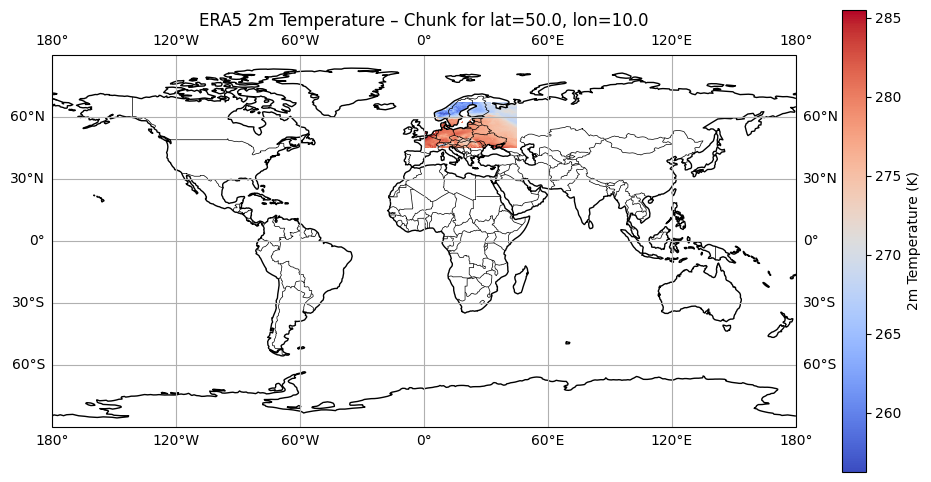

In [9]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load Zarr
ds = xr.open_zarr("era_t2m.zarr", consolidated=True)
array = ds["data"]
lat = ds["latitude"].values
lon = ds["longitude"].values

# Get chunk shape
chunk_shape = tuple(dim_chunks[0] for dim_chunks in array.chunks)
chunk_t, chunk_y, chunk_x = chunk_shape

# 🎯 Choose location
target_lat = 50.0  # e.g. Germany
target_lon = 10.0

# Find nearest lat/lon indices
lat_idx = np.argmin(np.abs(lat - target_lat))
lon_idx = np.argmin(np.abs(lon - target_lon))

# Find chunk indices
chunk_idx_y = lat_idx // chunk_y
chunk_idx_x = lon_idx // chunk_x
chunk_idx_t = 0  # first time step

# Build slices
ts = slice(chunk_idx_t * chunk_t, (chunk_idx_t + 1) * chunk_t)
ys = slice(chunk_idx_y * chunk_y, (chunk_idx_y + 1) * chunk_y)
xs = slice(chunk_idx_x * chunk_x, (chunk_idx_x + 1) * chunk_x)

# Extract chunk data
chunk_data = array[ts, ys, xs][0, :, :]
lat_chunk = lat[ys]
lon_chunk = lon[xs]
lon2d, lat2d = np.meshgrid(lon_chunk, lat_chunk)

# 🌍 Plot
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

img = ax.pcolormesh(lon2d, lat2d, chunk_data, cmap="coolwarm", shading="auto")
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.gridlines(draw_labels=True)

plt.colorbar(img, label="2m Temperature (K)")
plt.title(f"ERA5 2m Temperature – Chunk for lat={target_lat}, lon={target_lon}")
plt.show()

## Check Chunk by Function

In [10]:
# Get array shape and chunk sizes
data_shape = array.shape        # (time, lat, lon)
chunk_sizes = array.chunks      # tuple of tuples: ((4, 4, ...), (226, 226, ...), (450, 450, ...))

# Compute number of chunks in each direction
n_chunks_t = len(chunk_sizes[0])
n_chunks_y = len(chunk_sizes[1])
n_chunks_x = len(chunk_sizes[2])

print(f"Number of chunks:")
print(f" - Time:     {n_chunks_t}")
print(f" - Latitude: {n_chunks_y}")
print(f" - Longitude:{n_chunks_x}")

Number of chunks:
 - Time:     8
 - Latitude: 8
 - Longitude:8


In [11]:
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

def plot_chunk_by_index(array, lat, lon, chunk_idx_y, chunk_idx_x, ax=None, zoom=False):
    chunk_shape = tuple(dim_chunks[0] for dim_chunks in array.chunks)
    chunk_t, chunk_y, chunk_x = chunk_shape

    ts = slice(0, chunk_t)
    ys = slice(chunk_idx_y * chunk_y, (chunk_idx_y + 1) * chunk_y)
    xs = slice(chunk_idx_x * chunk_x, (chunk_idx_x + 1) * chunk_x)

    # Guard against empty slices
    if ys.stop > len(lat) or xs.stop > len(lon):
        ax.set_title(f"Invalid chunk ({chunk_idx_y}, {chunk_idx_x})")
        return

    data = array[ts, ys, xs][0, :, :]
    lat_chunk = lat[ys]
    lon_chunk = lon[xs]

    # Flip latitudes if descending
    if lat_chunk[0] > lat_chunk[-1]:
        lat_chunk = lat_chunk[::-1]
        data = data[::-1, :]

    lon2d, lat2d = np.meshgrid(lon_chunk, lat_chunk)

    
    if data.size == 0 or lat_chunk.size == 0 or lon_chunk.size == 0:
        ax.set_title(f"Empty chunk ({chunk_idx_y}, {chunk_idx_x})")
        return

    lon2d, lat2d = np.meshgrid(lon_chunk, lat_chunk)

    if ax is None:
        fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

    extent = [-180, 180, -90, 90] if not zoom else [
        lon_chunk[0], lon_chunk[-1], lat_chunk[-1], lat_chunk[0]]

    ax.set_extent(extent, crs=ccrs.PlateCarree())
    img = ax.pcolormesh(lon2d, lat2d, data, cmap="coolwarm", shading="auto")
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.gridlines(draw_labels=False)
    ax.set_title(f"Chunk y={chunk_idx_y}, x={chunk_idx_x}")
    return img

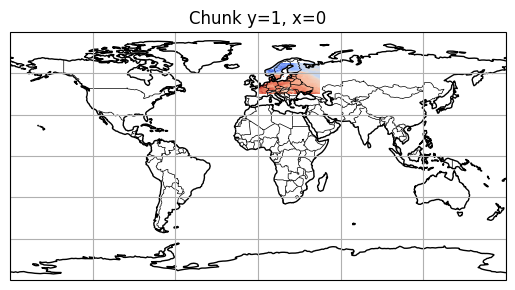

In [14]:
my_img=plot_chunk_by_index(array, lat, lon, 1, 0)
plt.savefig("era_zarr_1_0.png", dpi=150)

DEBUG: matplotlib.font_manager: findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=16.0.
DEBUG: matplotlib.font_manager: findfont: score(FontEntry(fname='/home/rolan/all/ropy_wsl/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG: matplotlib.font_manager: findfont: score(FontEntry(fname='/home/rolan/all/ropy_wsl/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG: matplotlib.font_manager: findfont: score(FontEntry(fname='/home/rolan/all/ropy_wsl/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/cmmi10.ttf', name='cmmi10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG: matplotlib.font_manager: findfon

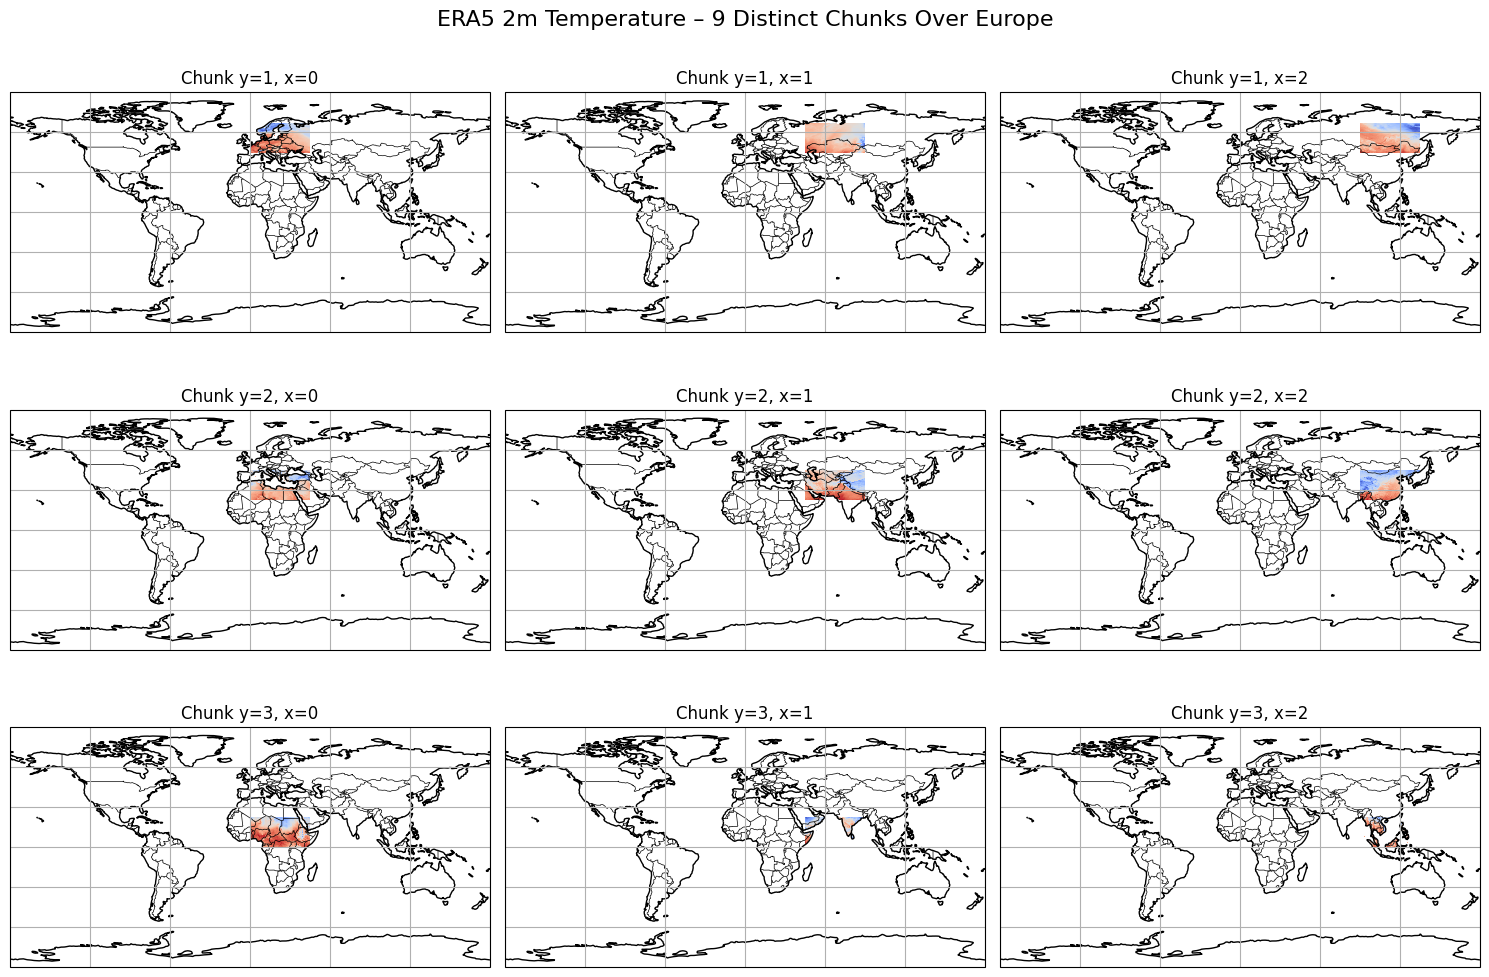

In [13]:
import xarray as xr

# Load Zarr
ds = xr.open_zarr("era_t2m.zarr", consolidated=True)
array = ds["data"]
lat = ds["latitude"].values
lon = ds["longitude"].values

# Get chunk dimensions
chunk_shape = tuple(dim_chunks[0] for dim_chunks in array.chunks)
_, chunk_y, chunk_x = chunk_shape

# Compute max valid chunk indices
max_y = len(lat) // chunk_y
max_x = len(lon) // chunk_x

# More readable: loop over lat (rows) and lon (cols)
chunk_indices = [(y, x) for y in range(1, 4) for x in range(0, 3)]

# Plot 3×3 grid
fig, axes = plt.subplots(3, 3, figsize=(15, 10),
                         subplot_kw={'projection': ccrs.PlateCarree()})

for ax, (lat_chunk_idx, lon_chunk_idx) in zip(axes.flat, chunk_indices):
    plot_chunk_by_index(array, lat, lon, lat_chunk_idx, lon_chunk_idx, ax=ax, zoom=False)

plt.tight_layout()
plt.suptitle("ERA5 2m Temperature – 9 Distinct Chunks Over Europe", fontsize=16, y=1.02)
plt.show()